### Import module we need

In [25]:
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

### Import Data

In [26]:
dcm_path = 'Input/Task3/blind/'
dcm_ct_l = os.listdir(dcm_path)
print(f"len(dcm_ct_l): {len(dcm_ct_l)}")
print(f"dcm_ct_l[:5]: {dcm_ct_l[:5]}")

len(dcm_ct_l): 125
dcm_ct_l[:5]: ['000000.dcm', '000001.dcm', '000002.dcm', '000003.dcm', '000007.dcm']


In [27]:
ct_slice_0 = pydicom.dcmread(dcm_path + dcm_ct_l[0])
print(ct_slice_0.pixel_array.shape)

(512, 512)


### Task 3.1 
![image](Input/Task3/task3_1.png)

3.1.1. From metadata, check image attributes such as ‘pixelSpacing’ and ‘SpacingBetweenSlices’

- `ct_slice_0.SpacingBetweenSlices`이 없는데..?

In [28]:
# ct_slice_0.SpacingBetweenSlices

In [29]:
ct_slice_0.PixelSpacing

[0.832031, 0.832031]

- 보다 확실한 체크를 위해 한번에 뽑아서 DICT 형식으로 놔두면 좋을 듯

In [30]:
ct_slice_0.dir()[:5]

['AccessionNumber',
 'AcquisitionDate',
 'AcquisitionNumber',
 'AcquisitionTime',
 'AdditionalPatientHistory']

In [31]:
meta_data_atr_l = ct_slice_0.dir()
meta_data_dict = dict(zip(meta_data_atr_l, [getattr(ct_slice_0, atr) for atr in meta_data_atr_l]))
meta_data_dict

{'AccessionNumber': '1800412745',
 'AcquisitionDate': '20180427',
 'AcquisitionNumber': '1',
 'AcquisitionTime': '102131.507',
 'AdditionalPatientHistory': '',
 'BitsAllocated': 16,
 'BitsStored': 16,
 'BodyPartExamined': 'UNKNOWN',
 'Columns': 512,
 'ContentDate': '20180427',
 'ContentTime': '102217',
 'ConvolutionKernel': 'STANDARD',
 'DataCollectionDiameter': '500.0',
 'DistanceSourceToDetector': '1097.61',
 'DistanceSourceToPatient': '625.61',
 'Exposure': '27',
 'ExposureTime': '456',
 'FilterType': 'BODY FILTER',
 'FocalSpots': '1.2',
 'FrameOfReferenceUID': '1.2.840.113619.2.416.239305910505007702453072198152204460922',
 'GantryDetectorTilt': '0.0',
 'GeneratorPower': '63000',
 'HighBit': 15,
 'ImageOrientationPatient': [1, 0, 0, 0, 1, 0],
 'ImagePositionPatient': [-208.104, -213, -80],
 'ImageType': ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO'],
 'InstanceCreationDate': '20180427',
 'InstanceCreationTime': '102217',
 'InstanceNumber': '1',
 'InstitutionName': 'PNUYH',
 'KVP': '1

In [32]:
meta_data_dict.keys()

dict_keys(['AccessionNumber', 'AcquisitionDate', 'AcquisitionNumber', 'AcquisitionTime', 'AdditionalPatientHistory', 'BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ContentDate', 'ContentTime', 'ConvolutionKernel', 'DataCollectionDiameter', 'DistanceSourceToDetector', 'DistanceSourceToPatient', 'Exposure', 'ExposureTime', 'FilterType', 'FocalSpots', 'FrameOfReferenceUID', 'GantryDetectorTilt', 'GeneratorPower', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'ImageType', 'InstanceCreationDate', 'InstanceCreationTime', 'InstanceNumber', 'InstitutionName', 'KVP', 'LargestImagePixelValue', 'Manufacturer', 'ManufacturerModelName', 'Modality', 'NameOfPhysiciansReadingStudy', 'OperatorsName', 'OtherPatientIDs', 'PatientAge', 'PatientBirthDate', 'PatientID', 'PatientName', 'PatientPosition', 'PatientSex', 'PerformedProcedureStepDescription', 'PerformedProcedureStepID', 'PerformedProcedureStepStartDate', 'PerformedProcedureStepStartTime', 'PerformingPhysicianName',

- test: pixeldSpacing and SpacingBetweenSlices

In [33]:
# get meta_data_dict keys that contain 'spacing'
spacing_keys = [key for key in meta_data_dict.keys() if 'spac' in key.lower()]
spacing_keys

['PixelSpacing']

In [34]:
pixel_keys = [key for key in meta_data_dict.keys() if 'pixel' in key.lower()]
pixel_keys

['LargestImagePixelValue',
 'PixelData',
 'PixelPaddingValue',
 'PixelRepresentation',
 'PixelSpacing',
 'SamplesPerPixel',
 'SmallestImagePixelValue']

In [35]:
slice_keys = [key for key in meta_data_dict.keys() if 'slice' in key.lower()]
slice_keys

['SliceLocation', 'SliceThickness']

- 우선 임시 방편으로 SliceThickness를 사용하며, 이전 데이터 기준으로 mm로 단위를 생각하고 진행

In [39]:
dx = ct_slice_0.PixelSpacing[0]
dy = ct_slice_0.PixelSpacing[1]
dz = ct_slice_0.SliceThickness
print(f"dx: {dx}mm, dy: {dy}mm, dz: {dz}mm")

dx: 0.832031mm, dy: 0.832031mm, dz: 2.5mm


In [42]:
x = dx*ct_slice_0.pixel_array.shape[1]/10
y = dy*ct_slice_0.pixel_array.shape[0]/10
z = dz*len(dcm_ct_l)/10
print(f"x: {x}cm, y: {y}cm, z: {z}cm")

x: 42.5999872cm, y: 42.5999872cm, z: 31.25cm


- 하나로 합쳐야 시점 변환이 가능할 것으로 예상

In [46]:
ct_l = []
for dcm in dcm_ct_l:
    ct_dcm = pydicom.dcmread(dcm_path + dcm)
    ct_l.append(pydicom.dcmread(dcm_path + dcm).pixel_array)
ct_a = np.dstack(ct_l)
ct_a.shape

(512, 512, 125)

In [49]:
ind = 24

In [50]:
transverse_slice = ct_a[:, :, ind]
sagittal_slice = ct_a[:, ind, :]
coronal_slice = ct_a[ind, :, :]

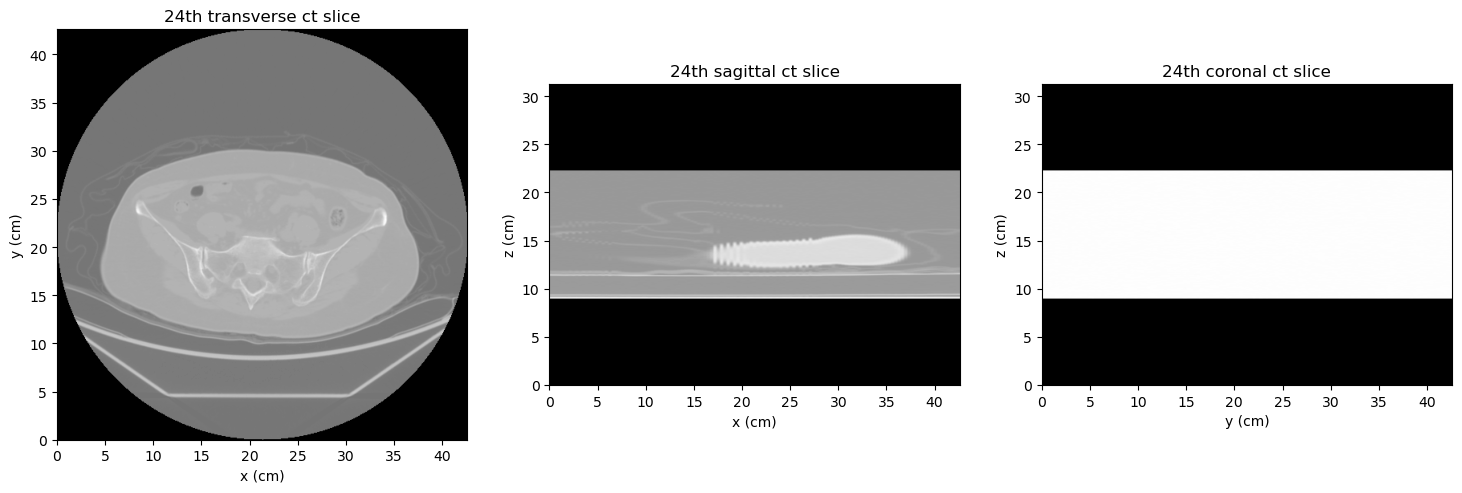

In [51]:
# draw dcm file's 24 index slice
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.title('24th transverse ct slice')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.imshow(transverse_slice, cmap='gray', extent=[0,x,0,y])
plt.subplot(132)
plt.title('24th sagittal ct slice')
plt.xlabel('x (cm)')
plt.ylabel('z (cm)')
plt.imshow(sagittal_slice, cmap='gray', extent=[0,x,0,z])
plt.subplot(133)
plt.title('24th coronal ct slice')
plt.xlabel('y (cm)')
plt.ylabel('z (cm)')
plt.imshow(coronal_slice, cmap='gray', extent=[0,y,0,z])

### Task 3.2.
![image](Input/Task3/task3_2.png)